In [3]:
# https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb#scrollTo=CKEzO1jzKydL

import urllib.request

url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
filename = 'airline-passengers.csv'
urllib.request.urlretrieve(url, filename)

('airline-passengers.csv', <http.client.HTTPMessage at 0x1063e2910>)

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as Func
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler

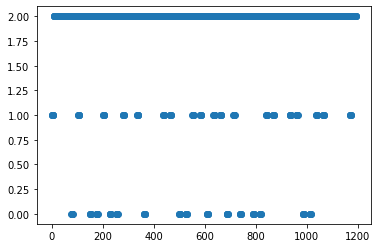

In [67]:
training_set = pd.read_csv('airline-passengers.csv')
training_set = training_set.iloc[:,1:2].values

plt.plot(actions, "o", label = 'Airline Passangers Data')
plt.show()

In [68]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length] # _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y) # train, val. data

#sc = MinMaxScaler()
#training_data = sc.fit_transform(actions)
training_data = actions

seq_length = 20
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [69]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        
        return out

In [74]:
print(len(trainX[0][0]))

1


In [60]:
val = 0

print('input (trainX):', trainX[val])
print('outputs:', outputs[val])
print('labels:', trainY[val])

print('')

print('length input (trainX):', len(trainX))
print('length outputs:', len(outputs))
print('length labels:', len(trainY))

input (trainX): tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.]])
outputs: tensor([1.9847], grad_fn=<SelectBackward0>)
labels: tensor([2.])

length input (trainX): 786
length outputs: 793
length labels: 786


In [61]:
outputs = lstm(trainX[0:1])

print(outputs)

tensor([[1.8788]], grad_fn=<AddmmBackward0>)


In [86]:
'''
best value: 0.07111 (hidden size of 20) - but overall little to no diff.
best value: 0.06789 (with a seq. length of 20)
increasing the length of the sequence length concidered 
for making the next decision, the better the resulting prediction

'''

num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 20
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss() # MSELoss - regression, CrossEntropyLoss for labels
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 200 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 3.06959
Epoch: 200, loss: 0.07958
Epoch: 400, loss: 0.07234
Epoch: 600, loss: 0.07231
Epoch: 800, loss: 0.08511
Epoch: 1000, loss: 0.07066
Epoch: 1200, loss: 0.07284
Epoch: 1400, loss: 0.07008
Epoch: 1600, loss: 0.06900
Epoch: 1800, loss: 0.06824


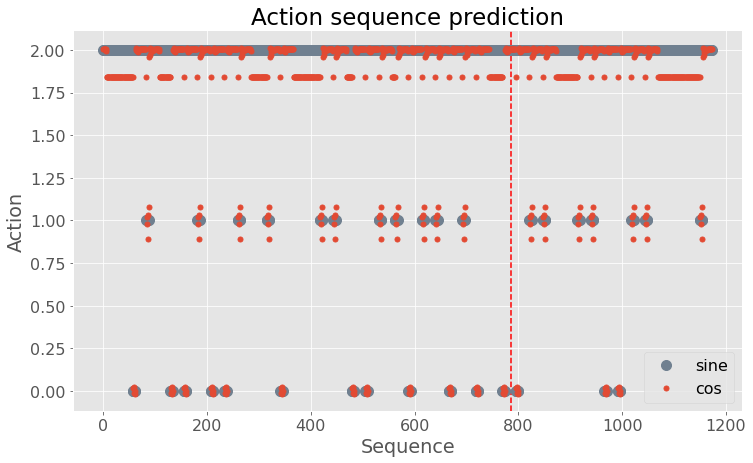

In [94]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()



#data_predict = sc.inverse_transform(data_predict)
#dataY_plot = sc.inverse_transform(dataY_plot)

with plt.style.context('ggplot'):
    plt.figure(figsize=(12, 7))
    plt.rcParams.update({'font.size': 16})
    plt.axvline(x=train_size, c='r', linestyle='--')

    plt.plot(dataY_plot, 'o', color='slategray', markersize=10, label="sine")
    plt.plot(data_predict, 'o', markersize=5, label="cos")
    
    #plt.legend(['Training Acc', 'Validation Acc'])
    plt.legend(loc="lower right")
    plt.title('Action sequence prediction')
    plt.xlabel('Sequence')
    plt.ylabel('Action')
    plt.show()


In [1]:
def oracle_actions():
    # optimal action seq. for this maze only (seed 0)
    # 0 - turn left, 1 - turn right, 2 - walk forwards, 3 - walk backwards
    actions = []
    actions = actions + [1]*7 # angle 270, current-pos: (2.16, 0.00, 7.49) - turn right
    actions = actions + [2]*70 # angle 270, current-pos: (2.01, 0.00, 16.48) - walk forwards
    actions = actions + [0]*6 # angle 83, current-pos: (1.98, 0.00, 17.98) - turn left
    actions = actions + [2]*20 # angle 0,  current-pos: (4.98, 0.00, 18.04) - walk forwards
    actions = actions + [1]*6 # angle 270, current-pos: (4.98, 0.00, 18.04) - turn right
    actions = actions + [2]*40 # angle 270, current-pos: (4.88, 0.00, 24.03) - walk forwards
    actions = actions + [0]*6 # angle 0, current-pos: (4.88, 0.00, 24.03) - turn left
    actions = actions + [2]*20 # angle 0, current-pos: (7.88, 0.00, 24.09) - walk forwards
    actions = actions + [0]*6 # angle 89, current-pos: (7.88, 0.00, 24.09) - turn left
    actions = actions + [2]*20 # angle 89, current-pos: (7.93, 0.00, 21.09) - walk forwards
    actions = actions + [1]*6 # angle 0, current-pos: (7.93, 0.00, 21.09)- turn right
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [0]*6 #  - turn left
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [0]*6 #  - turn left
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [1]*6 # - turn right
    actions = actions + [2]*50 # - walk forwards
    actions = actions + [1]*6 # - turn right
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [0]*6 #  - turn left
    actions = actions + [2]*70 # - walk forwards
    actions = actions + [1]*6 # - turn right
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [1]*6 # - turn right
    actions = actions + [2]*30 # - walk forwards
    actions = actions + [0]*6 #  - turn left
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [0]*6 #  - turn left
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [1]*6 # - turn right
    actions = actions + [2]*25 # - walk forwards
    actions = actions + [1]*6 # - turn right
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [0]*6 #  - turn left
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [1]*6 # - turn right
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [1]*6 # - turn right
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [0]*6 #  - turn left
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [1]*6 # - turn right
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [0]*6 #  - turn left
    actions = actions + [2]*45 # - walk forwards
    actions = actions + [0]*6 # - turn right
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [0]*6 #  - turn left
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [1]*6 # - turn right
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [1]*6 # - turn right
    actions = actions + [2]*60 # - walk forwards
    actions = actions + [1]*6 # - turn right
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [1]*6 # - turn right
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [0]*6 #  - turn left
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [0]*6 #  - turn left
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [1]*6 # - turn right
    actions = actions + [2]*20 # - walk forwards
    actions = actions + [1]*6 # - turn right
    actions = actions + [2]*100 # - walk forwards
    actions = actions + [1]*6 # - turn right
    actions = actions + [2]*20 # - walk forwards

    return actions

In [2]:
actions = oracle_actions()
actions = [[i] for i in actions]